In [1]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
%cd '/home/ec2-user/SageMaker/dl-ecommerce-duplicates/'

/home/ec2-user/SageMaker/dl-ecommerce-duplicates


In [3]:
### Imports
import timm
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from modules.models.BertWithArcFace import BertWithArcFace
from modules.datasets.TextArcFaceLossShopeeDataset import TextArcFaceLossShopeeDataset
from modules.models.DenseNet import DenseNet
from torch.utils.data import Dataset,DataLoader
import transformers
import os
import torch
import torch.nn as nn
from tqdm import tqdm
import gc
from modules.cfg.DenseNetArcFaceLossCFG import DenseNetArcFaceLossCFG as CFG
from modules.datasets.ImageArcFaceLossShopeeDataset import ImageArcFaceLossShopeeDataset
from modules.models.DenseNet import DenseNet
import torchvision.transforms as transforms
from modules.datasets.ImageShopeeDataset import ImageShopeeDataset
from modules.utils.EmbeddingsProducer import EmbeddingsProducer
from modules.utils.F1ScoreEvaluator import F1ScoreEvaluator
from modules.utils.CommonVIsualizer import CommonVisualizer
import modules.utils.dataset_utils as dataset_utils
from modules.models.ResNet18EmbeddingsShopeeNet import ResNet18EmbeddingsShopeeNet
from modules.models.ImageShopeeNet import ImageShopeeNet
import matplotlib.pyplot as plt

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [4]:
#Configurations
device = torch.device('cuda')
transformer_model = 'sentence-transformers/paraphrase-xlm-r-multilingual-v1'
tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_model)
model_params = {
    'n_classes':11014,
    'model_name':transformer_model,
    'pooling':'clf',
    'use_fc':False,
    'fc_dim':512,
    'dropout':0.0,
    'loss_module':"arcface",
    's':30.0,
    'margin':0.50,
    'ls_eps':0.0,
    'theta_zero':0.785,
    'mode_train':True
}
NUM_WORKERS = 4
BATCH_SIZE = 32
IMG_SZ = 512

DATA_FOLDER = "../shopee-product-matching/"
thresholds = np.arange(.4,.99,.05)

In [5]:
def get_text_embeddings(df,text_model_path):
    embeds = []
    losses = []
    model_params['mode_train'] = False
    model = BertWithArcFace(**model_params)
    model.eval()
    
    model.load_state_dict(dict(list(torch.load(text_model_path).items())[:-1]),strict=False)
    model = model.to(device)

    text_dataset = TextArcFaceLossShopeeDataset(tokenizer,df)
    text_loader = torch.utils.data.DataLoader(
        text_dataset,
        batch_size=BATCH_SIZE,
        pin_memory=True,
        drop_last=False,
        num_workers=NUM_WORKERS
    )
    
    criterion = nn.CrossEntropyLoss().to(device)
    
    with torch.no_grad():
        for input_ids, attention_mask,labels in tqdm(text_loader): 
            input_ids = input_ids.cuda()
            attention_mask = attention_mask.cuda()
            labels = labels.cuda()
            feat,outputs = model(input_ids, attention_mask,labels)
            text_embeddings = feat.detach().cpu().numpy()
            embeds.append(text_embeddings)
            
            # Compute the validation loss
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    
    loss_valid = np.mean(losses)
    
    del model
    text_embeddings = np.concatenate(embeds)
    print(f'Our text embeddings shape is {text_embeddings.shape}')
    del embeds
    gc.collect()
    return text_embeddings,loss_valid
    # return text_embeddings

In [6]:
def get_image_embeddings(df,model,normalize=True):
    img_transforms = transforms.Compose([
        transforms.Resize((IMG_SZ, IMG_SZ)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = ImageShopeeDataset(
        df['image'].values,
        img_transforms,
    )
    
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=64,
        shuffle=False,
        num_workers=0
        )
    
    producer = EmbeddingsProducer(model, device)
    embeddings = producer.get_embeddings(loader, normalize)
    embeddings = embeddings.squeeze()

    return embeddings

In [7]:
# def combine_predictions(row):
#     x = np.concatenate([row['image_predictions'], row['text_predictions']])
#     return ' '.join( np.unique(x) )

In [8]:
def read_dataset(file):
    df = pd.read_csv(file)
    tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
    df['target'] = df['label_group'].map(tmp)
    df['target'] = df['target'].apply(lambda x: ' '.join(x))
    grouped = df.groupby('label_group')['posting_id'].apply(list)
    df['target'] = df['label_group'].map(grouped)
    return df

In [9]:
#Training Data Set
file = '../shopee-product-matching/train80.csv'
train_df = read_dataset(file)
train_df['label_group'] = LabelEncoder().fit_transform(train_df['label_group'])

#Validation Dataset
file = '../shopee-product-matching/valid20.csv'
valid_df = read_dataset(file)
valid_df['label_group'] = LabelEncoder().fit_transform(valid_df['label_group'])

#Full Dataset
file = '../shopee-product-matching/train.csv'
full_df = read_dataset(file)
full_df['label_group'] = LabelEncoder().fit_transform(full_df['label_group'])

# Get Text Embeddings from XLM + Arcface

In [10]:
text_model_path = 'results/xlm_arcface_10_epochs.bin'
valid_text_embeddings,val = get_text_embeddings(valid_df,text_model_path)
train_text_embeddings,val = get_text_embeddings(train_df,text_model_path)
full_text_embeddings,val = get_text_embeddings(full_df,text_model_path)

100%|██████████| 215/215 [00:21<00:00,  9.93it/s]


Our text embeddings shape is (6851, 768)


100%|██████████| 857/857 [01:26<00:00,  9.87it/s]


Our text embeddings shape is (27399, 768)


100%|██████████| 1071/1071 [01:55<00:00,  9.27it/s]


Our text embeddings shape is (34250, 768)


# Get Image Embeddings from Densenet + ArcFace

In [11]:
train_df = dataset_utils.get_dataset(DATA_FOLDER, is_test=False, file_name='train80.csv')
train_df = dataset_utils.add_target(train_df)

valid_df = dataset_utils.get_dataset(DATA_FOLDER, is_test=False, file_name='valid20.csv')
valid_df = dataset_utils.add_target(valid_df)

full_df = train_df.append(valid_df, ignore_index=True)

/tmp/ipykernel_8398/1440199373.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = train_df.append(valid_df, ignore_index=True)


In [12]:
image_model_path = 'results/densenet_512_epoch29.pth'
model = DenseNet(512, 11014)
model.load_state_dict(torch.load(image_model_path, map_location='cuda:0'))
model = model.to(device)

In [13]:
valid_image_embeddings = get_image_embeddings(valid_df,model,normalize=True)
train_image_embeddings = get_image_embeddings(train_df,model,normalize=True)
full_image_embeddings = get_image_embeddings(full_df,model,normalize=True)

100%|██████████| 536/536 [17:01<00:00,  1.91s/it]


# Combining Text and Image Embeddings

In [14]:
# Concatenate the two embeddings
valid_combined_embeddings = np.concatenate([valid_image_embeddings, valid_text_embeddings], 1)
train_combined_embeddings = np.concatenate([train_image_embeddings, train_text_embeddings], 1)
full_combined_embeddings = np.concatenate([full_image_embeddings, full_text_embeddings], 1)

In [19]:
# valid_combined_embeddings = EmbeddingsProducer(torch.nn.Module,device).embeddings_normalizer(embeddings=valid_combined_embeddings)
valid_img_f1_scores = F1ScoreEvaluator(valid_df,valid_image_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
valid_text_f1_scores = F1ScoreEvaluator(valid_df,valid_text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
valid_combined_f1_scores = F1ScoreEvaluator(valid_df,valid_combined_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)

train_img_f1_scores = F1ScoreEvaluator(train_df,train_image_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
train_text_f1_scores = F1ScoreEvaluator(train_df,train_text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
train_combined_f1_scores = F1ScoreEvaluator(train_df,train_combined_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)

full_img_f1_scores = F1ScoreEvaluator(full_df,full_image_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
full_text_f1_scores = F1ScoreEvaluator(full_df,full_text_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)
full_combined_f1_scores = F1ScoreEvaluator(full_df,full_combined_embeddings,k=100).get_avg_f1_scores_for_thresholds(thresholds)

100%|██████████| 12/12 [02:16<00:00, 11.38s/it]


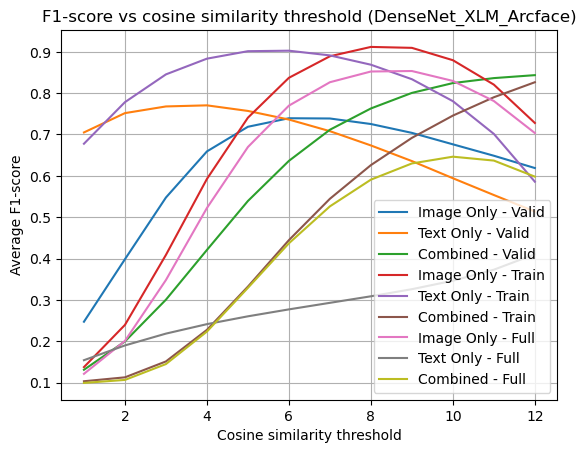

In [22]:
results_folder = "results/"
model_name = "DenseNet_XLM_Arcface"
filename = os.path.join('results/', 'combined_' + model_name) 
CommonVisualizer(). \
    plt_combined_f1_score(
        valid_img_f1_scores, 
        valid_text_f1_scores, 
        valid_combined_f1_scores, 
        train_img_f1_scores, 
        train_text_f1_scores, 
        train_combined_f1_scores, 
        full_img_f1_scores, 
        full_text_f1_scores, 
        full_combined_f1_scores, 
        model_name, 
        filename)